In [32]:
import tweepy
import json
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.weightstats import _zstat_generic as zg
%matplotlib notebook

In [26]:
plt.style.use('fivethirtyeight')

## 1. Load and authenticate credentials

In [6]:
# load twitter credentials
with open('twitter_cred.json') as cred:
    credentials = json.load(cred)


consumer_key = credentials.get('consumer_key')
consumer_secret = credentials.get('consumer_secret')
access_token = credentials.get('access_token')
access_secret = credentials.get('access_secret')

# authenticate with twitter api using OAuth1a
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

## 2. Get tweets

In [8]:
# Tweets that refer to the virus as corona or coronavirus. Filter is case-insensitive
tweets = tweepy.Cursor(api.search, q='corona+masks -filter:retweets', lang='en',since='2020-12-01').items(10000)
tweet_text = [[tweet.user.location,tweet.user.screen_name,tweet.text] for tweet in tweets]
df_corona = pd.DataFrame(data=tweet_text, columns=['Location','User_name','Tweets'])

# Tweets that refer to the virus as COVID or COVID-19. Filter is case insensitive
tweets = tweepy.Cursor(api.search, q='covid+masks -filter:retweets', lang='en',since='2020-12-01').items(10000)
tweet_text = [[tweet.user.location,tweet.user.screen_name,tweet.text] for tweet in tweets]
df_covid = pd.DataFrame(data=tweet_text, columns=['Location','User_name','Tweets'])

## 3. Clean tweets

In [9]:
def clean_text(text):
 cleaned_text = re.sub('@[A-Za-z0–9]+', '', text) # Removing @mentions
 cleaned_text = re.sub('#', '', cleaned_text) # Removing '#' hash tag
 cleaned_text = re.sub('RT[\s]+', '', cleaned_text) # Removing RT
 cleaned_text = re.sub('https?:\/\/\S+', '', cleaned_text) # Removing hyperlink
 
 return cleaned_text


df_corona['Tweets'] = df_corona['Tweets'].apply(clean_text)
df_covid['Tweets'] = df_covid['Tweets'].apply(clean_text)



## 4. Get polarity and subjectivity of tweets 

In [10]:
# Textblob's subjectivity method scores the tweet in [0,1] s.t. 1 = Most Subjective , 0 = Most Objective
df_corona['Subjectivity'] = df_corona['Tweets'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
# Textblob's polarity method scores the tweet between [-1,1] s.t. -1 = Most Negative (or Disapprove), 0 = Neutral, 1 = Most Positive (or Approve)
df_corona['Polarity'] = df_corona['Tweets'].apply(lambda text: TextBlob(text).sentiment.polarity)
# Categorize tweets by assigning labels
df_corona['Analysis'] = df_corona['Polarity'].apply(lambda score: 'Neutral' if score == 0 else ('Approve' if score > 0 else 'Disapprove'))

# Repeat the same for COVID group data
df_covid['Subjectivity'] = df_covid['Tweets'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
df_covid['Polarity'] = df_covid['Tweets'].apply(lambda text: TextBlob(text).sentiment.polarity)
df_covid['Analysis'] = df_covid['Polarity'].apply(lambda score: 'Neutral' if score == 0 else ('Approve' if score > 0 else 'Disapprove'))

## 5. Plot and compare sentiments among groups 

<IPython.core.display.Javascript object>


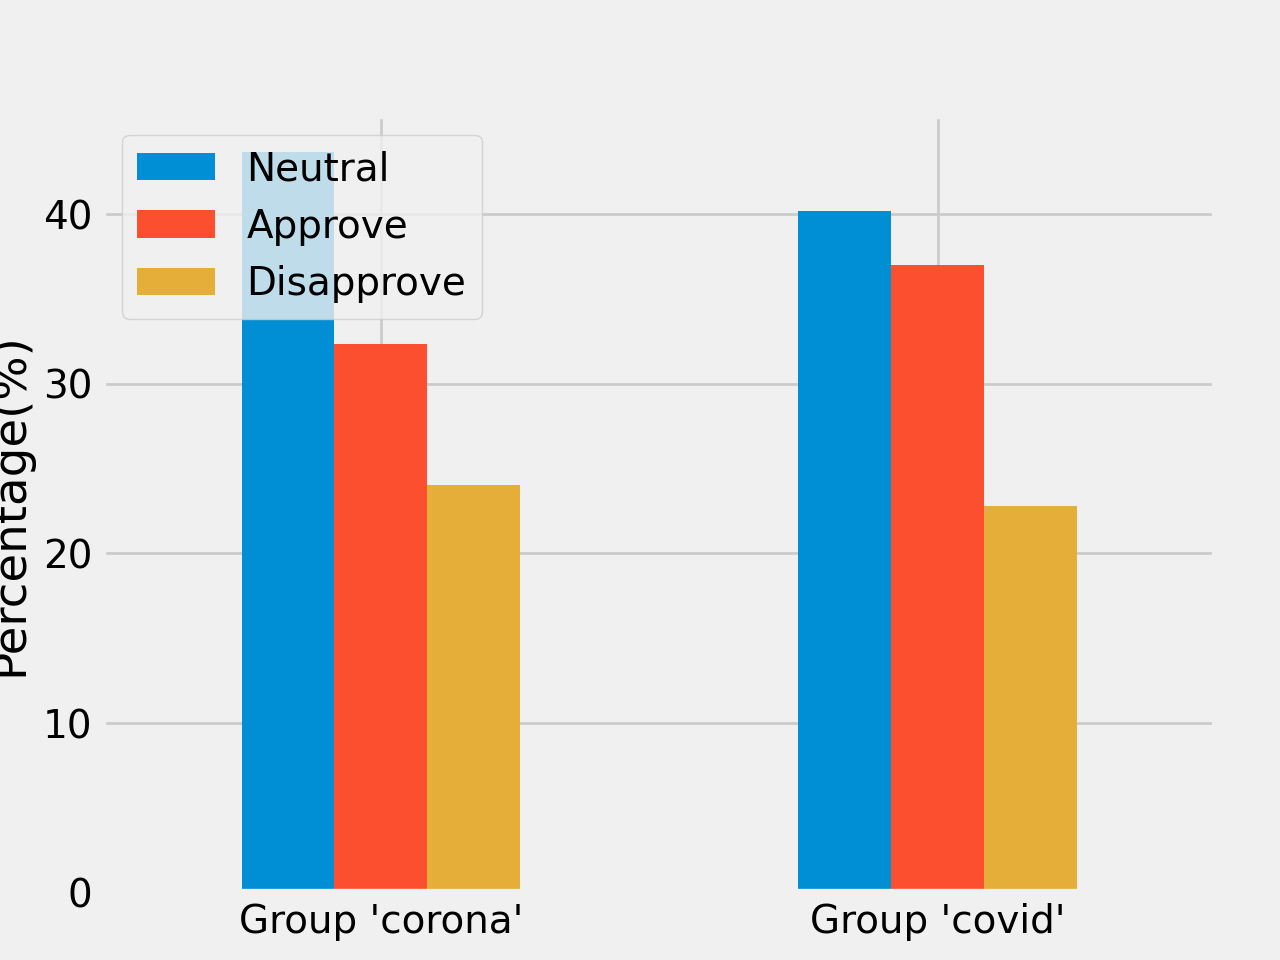

In [33]:
pd.DataFrame({"Group 'corona'":dict(df_corona['Analysis'].value_counts(normalize=True)*100),
             "Group 'covid'":dict(df_covid['Analysis'].value_counts(normalize=True)*100)}).T.plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.ylabel('Percentage(%)')
plt.show()

## 6. Test hypothesis 

In [38]:
"""
People who refer to the virus as 'COVID' or 'COVID-19' are more likely to approve wearing masks as opposed\
to people who refer to the virus as 'corona' or 'coronavirus'. The implication is the latter group of people are \
more likely to be dismissive about the pandemic. Furthermore 'corona' is a nod to a popular beer brand.
"""
# the approval rate in the 'covid' group is 38%
# the aproval rate in the 'corona' group is 32%
# the combined std.dev for the test-statistic is calculated using\
# the formula :https://www.socscistatistics.com/tests/ztest/default.aspx 
z_value, p_value=zg(value1=0.38,value2=0.32,std_diff=0.011,alternative='larger')
if p_value > 0.05:
    print('Accept the null hypothesis that the two approval rates are the same')
else:
    print('Adopt alternate hypothesis that the approval rates are different')

Adopt alternate hypothesis that the approval rates are different


## 7. Plot to understand interplay between Subjectivity and Polarity

<IPython.core.display.Javascript object>


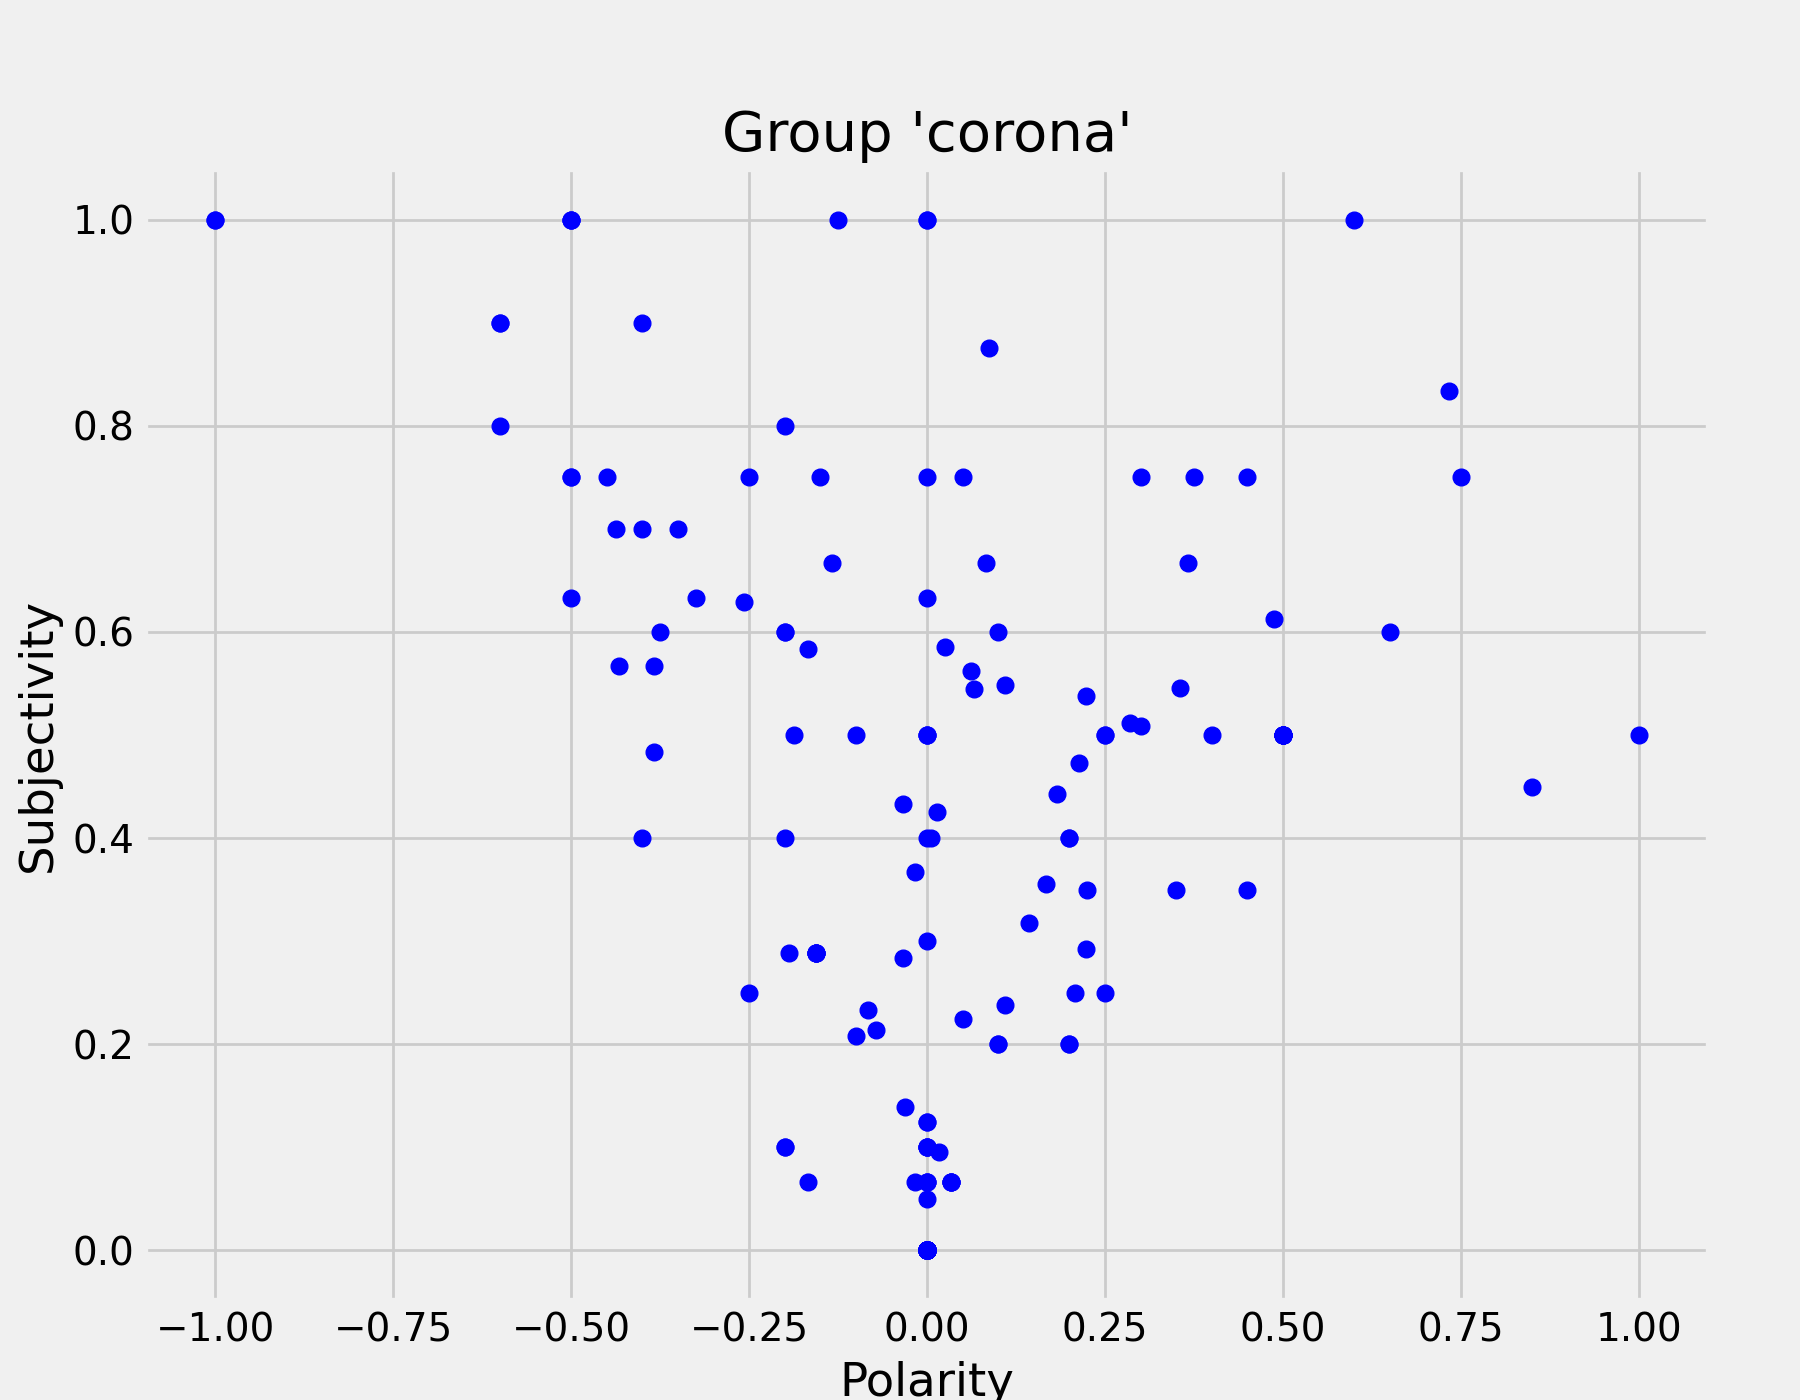

In [45]:
# Plotting by sampling a subset of tweets
plt.figure(figsize=(9,7)) 
for i in range(0, df_corona.shape[0],10):
  plt.scatter(df_corona["Polarity"][i], df_corona["Subjectivity"][i], color='Blue') 
plt.title("Group 'corona'") 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

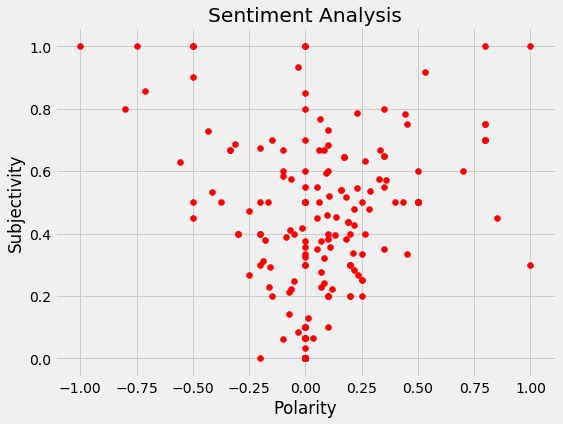

In [0]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, df_covid.shape[0],40):
  plt.scatter(df_covid["Polarity"][i], df_covid["Subjectivity"][i], color='Red') 
plt.title("Group 'covid'") 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

In [39]:
# Save data for possible future use
df_covid.to_csv('COVID.csv',index=False)
df_corona.to_csv('Corona.csv', index=False)

In [0]:
#source : https://www.youtube.com/watch?v=ujId4ipkBio&list=TLPQMDgxMjIwMjBInCbigCegFg&index=4